# RAG example


In [1]:
!pip install datasets
!pip install python-dotenv
!pip install -U langchain-community
!pip install pypdf
!pip install chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

# Pipeline



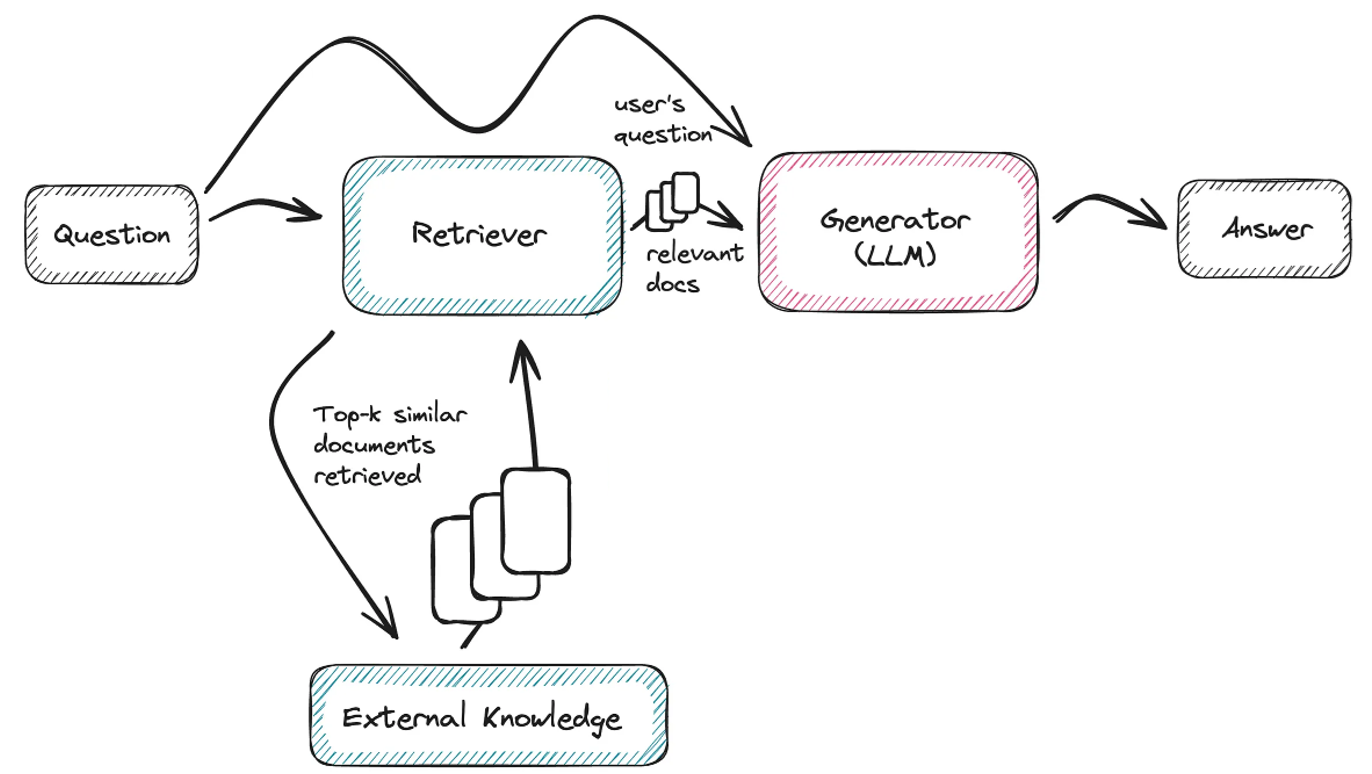

In [2]:
import os
import openai
import pandas as pd
from datasets import Dataset
from dotenv import dotenv_values
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
#from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
##from langchain_openai import OpenAI
from langchain.chains import RetrievalQA
import warnings

# Suppress all user warnings
warnings.filterwarnings("ignore")

## LangChain
To build our RAG system, we will use the [LangChain](https://www.langchain.com/) framework.

LangChain is an open source orchestration framework for the development of applications using large language models (LLMs).

LangChain serves as a generic interface for nearly any LLM, providing a centralized development environment to build LLM applications and integrate them with external data sources and software workflows. LangChain’s module-based approach allows developers and data scientists to dynamically compare different prompts and even different foundation models with minimal need to rewrite code. This modular environment also allows for programs that use multiple LLMs: for example, an application that uses one LLM to interpret user queries and another LLM to author a response.



### Knowledge base:

LangChain provides several in-built document loaders that work with PDFs, JSONs, or Python files in your file directory.  We can use  `PyPDFLoader` in LangChain to import PDF.

As a knowledge base today, we will use the first Chapter of the [Artificial Intelligence Index Report 2024](https://aiindex.stanford.edu/report/). It tracks, collates, distills, and visualizes data related to artificial intelligence (AI). Their goal is to provide unbiased, rigorously vetted, broadly sourced data in order for policymakers, researchers, executives, journalists, and the general public to develop a more thorough and nuanced understanding of the complex field of AI.

In [4]:
!wget -O Chapter1.pdf https://drive.usercontent.google.com/download?id=1A8Wvv3r4PHzQaejC8X4V_18yaguBO8wv&export=download&authuser=0&confirm=t&uuid=c1bed830-277a-43ec-8a96-89a1fe9edbcc&at=AENtkXbuvcf-TaYB5KBQqx4IQICY:1732368617222

--2025-04-22 16:49:57--  https://drive.usercontent.google.com/download?id=1A8Wvv3r4PHzQaejC8X4V_18yaguBO8wv
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.118.132, 2404:6800:4003:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3112904 (3.0M) [application/octet-stream]
Saving to: ‘Chapter1.pdf’

Chapter1.pdf        100%[===================>]   2.97M  --.-KB/s    in 0.03s   

2025-04-22 16:50:06 (104 MB/s) - ‘Chapter1.pdf’ saved [3112904/3112904]



In [5]:
# load document
loader = PyPDFLoader("Chapter1.pdf")
documents = loader.load()

### Document chunking

When a document is long, we need to divide it into parts. There are different ways to split text. Let's use the most straightforward method `CharacterTextSplitter`, which splits text by characters and measures the length of the fragment by the number of characters.

In [7]:
# split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

### Text embeddings:

The text fragments are then transformed into sentence embeddings, which allows us to handle text data, as in semantic search, in a computationally efficient way. For this task, we can choose any sentence embedder, for example, [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), which maps sentences and paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search

In [8]:
# select which embeddings we want to use
from langchain.embeddings import HuggingFaceEmbeddings
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Vector database

Then, we need to store the embedding vectors in a vector database, which allows us to search and retrieve the corresponding vectors during queries.

In [9]:
# create the vectorestore to use as the index
db = Chroma.from_documents(texts, embeddings)

### Retriever interface

To retrieve the text, we can select a search type such as "similarity" to use similarity search in the retriever object, where it selects the text fragment vectors that are most similar to the question vector.

The `k=2` allows us to find the 2 most relevant text snippet vectors.

In [10]:
# expose this index in a retriever interface
retriever = db.as_retriever(
    #search_type='mmr',
    search_type="similarity",
    search_kwargs={"k": 2}
)

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline

# Load the Qwen model and tokenizer
# The model_name specifies the pretrained Qwen model to be used
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)  # Initialize tokenizer with remote code trust
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="auto")  # Load model with device mapping

# Create a Hugging Face text-generation pipeline
hf_pipeline = pipeline(
    "text-generation",  # Specify the task type
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,  # Set the maximum number of tokens the model can generate in a single response
    do_sample=False  # Disable sampling for more deterministic outputs
)

# Integrate the Hugging Face pipeline into LangChain
llm = HuggingFacePipeline(pipeline=hf_pipeline)

# Create a RetrievalQA chain for answering questions
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,  # Specify the language model to use
    chain_type="map_reduce",  # Use a map-reduce chain type for efficient large-scale queries
    retriever=retriever,  # Define the retriever to handle document searches
    return_source_documents=True,  # Return source documents along with the generated answers
    verbose=True  # Enable detailed logging for better debugging and monitoring
)


Device set to use cuda:0


In [13]:

def truncate_input(query, tokenizer, max_input_length=512):
    """
    Truncates the input text to ensure its tokenized length does not exceed the specified maximum.
    """
    # Tokenize the input query with truncation to the maximum allowed token length
    tokens = tokenizer.encode(query, truncation=True, max_length=max_input_length)

    # Decode the truncated tokens back into a readable string
    return tokenizer.decode(tokens)




Let us try to find information about the GPT-4 training cost.

In [14]:
query = "What was the training cost of GPT-4?"
query = truncate_input(query, tokenizer, max_input_length=512)
result = qa_chain.invoke(query)




> Entering new RetrievalQA chain...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2721 > 1024). Running this sequence through the model will result in indexing errors



> Finished chain.


Let's look at what we have found.

In [15]:

for document in result["source_documents"]:
    print(document.metadata)



{'creationdate': '2024-04-21T08:49:08-07:00', 'source': 'Chapter1.pdf', 'total_pages': 51, 'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 19.3 (Macintosh)', 'page_label': '39', 'moddate': '2024-04-21T08:49:11-07:00', 'trapped': '/False', 'page': 38}
{'trapped': '/False', 'creator': 'Adobe InDesign 19.3 (Macintosh)', 'page_label': '37', 'producer': 'Adobe PDF Library 17.0', 'total_pages': 51, 'moddate': '2024-04-21T08:49:11-07:00', 'creationdate': '2024-04-21T08:49:08-07:00', 'source': 'Chapter1.pdf', 'page': 36}


In [16]:
result.keys()

dict_keys(['query', 'result', 'source_documents'])

In [ ]:
result['result']

"Given the following extracted parts of a long document and a question, create a final answer. \nIf you don't know the answer, just say that you don't know. Don't try to make up an answer.\n\nQUESTION: Which state/country's law governs the interpretation of the contract?\n=========\nContent: This Agreement is governed by English law and the parties submit to the exclusive jurisdiction of the English courts in  relation to any dispute (contractual or non-contractual) concerning this Agreement save that either party may apply to any court for an  injunction or other relief to protect its Intellectual Property Rights.\n\nContent: No Waiver. Failure or delay in exercising any right or remedy under this Agreement shall not constitute a waiver of such (or any other)  right or remedy.\n\n11.7 Severability. The invalidity, illegality or unenforceability of any term (or part of a term) of this Agreement shall not affect the continuation  in force of the remainder of the term (if any) and this A

Seems that the result needs some postprocessing.

In [17]:
result['result'].split('FINAL ANSWER:')[-1].split('Relevant text from the passage:')[0].strip()

'The training cost of GPT-4 is over $100 million.'

# Naive example

Let's compare these answers with the raw QWEN 2.5 answers. We will generate naive LLM responses using `Qwen/Qwen2.5-1.5B-Instruct` without our RAG.

In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load Qwen model and tokenizer for text generation
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)  # Initialize tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="auto")  # Load model with device mapping

# Set up a text generation pipeline using Hugging Face
text_gen_pipeline = pipeline(
    "text-generation",  # Define task type as text generation
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=100,  # Limit the output to 100 tokens
    do_sample=True,  # Enable sampling for variability
    temperature=0.01  # Low temperature for deterministic responses
)

def generate_naive_llm_response(question):
    """
    Generate a response to a given question using the Qwen model.

    Parameters:
        question (str): The user's question or input query.

    Returns:
        str: The generated response text from the model.


    """
    # Generate a response using the text generation pipeline
    chat_response = text_gen_pipeline(question)[0]["generated_text"]  # Extract generated text

    # Print and return the generated response
    print(chat_response.strip())  # Display response without leading/trailing spaces
    return chat_response.strip()  # Return the processed response text

# Example usage
query = "What are the main principles of artificial intelligence?"
response = generate_naive_llm_response(query)  # Generate and print the response


Device set to use cpu


What are the main principles of artificial intelligence? Artificial Intelligence (AI) is a rapidly evolving field that aims to create intelligent machines capable of performing tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation. The main principles of AI include:

1. Machine Learning: This involves training algorithms on large datasets to learn patterns and make predictions or decisions without being explicitly programmed.

2. Deep Learning: A subset of machine learning that uses neural networks with multiple layers to model complex relationships between inputs and outputs.

3


In [ ]:
query = "What was the training cost of GPT-4?"
response = generate_naive_llm_response(query)  # Generate and print the response

What was the training cost of GPT-4? I'm sorry, but there is no publicly available information about the training cost of GPT-4. The development and release of large language models like GPT-4 are a closely guarded secret by their creators, including OpenAI. They typically do not disclose details about the resources or costs associated with developing these models.
It's worth noting that the training process for large language models can be very resource-intensive, involving significant amounts of computing power and data. However, without more specific information from the developers
